# BitBIRCH best practices

This is a tutorial notebook that showcases a simple workflow of BitBIRCH clustering, incluiding threshold selection, and the refinement of singletons.

- [BitBIRCH: efficient clustering of large molecular libraries](https://doi.org/10.1039/D5DD00030K)
- [BitBIRCH Clustering Refinement Strategies](https://doi.org/10.1021/acs.jcim.5c00627)
- [BitBIRCH-Lean](TO-BE-ADDED)

Please reach out to one of the following with any questions or concerns. 

- Ramon Alain Miranda Quintana: `quintana At chem.ufl.edu`
- Kenneth Lopez Perez: `klopezperez At chem.ufl.edu`
- Ignacio Pickering: `ipickering At chem.ufl.edu`
- Krisztina Zsigmond: `kzsigmond At ufl.edu`
- Miroslav Lzicar: `miroslav.lzicar At deepmedchem.com`

## Set Up

First lets install the BitBirch-Lean package (if you have not already done so). To do
this, run the following commands in your terminal:

```
git clone https://github.com/mqcomplab/bblean.git
cd bblean
pip install -v .
```

Lets import the `bblean` package and some bblean modules, which we will use throughout
this example.

In [1]:
import bblean
import bblean.plotting as plotting
import bblean.analysis as analysis
import bblean._py_similarity as iSIM
import numpy as np

/home/kenneth/bblean/bblean/similarity.py:98: UserWarning: C++ optimized similarity calculations not available, falling back to python implementation
  warnings.warn(


Now let's take some SMILES strings and compute molecular fingerprints:

In [2]:
smiles = bblean.load_smiles("./chembl-33-natural-products-subset.smi", max_num=10000)

# By default the fps created are of the "ecfp4" kind. Here we use "rdkit"
fps = bblean.fps_from_smiles(smiles, pack=True, n_features=2048, kind="ecfp4")
print(f"Shape: {fps.shape}, DType: {fps.dtype}")

Shape: (10000, 256), DType: uint8


The most efficient way to store and manipulate fingerprints is using *packed*
fingerprint arrays. Packed arrays save the features in a compressed representation. To
convert between packed and unpacked fingerprints you can use
`bblean.pack_fingerprints(fps)` and `bblean.unpack_fingerprints(fps)`.

In [3]:
fps_unpacked = bblean.unpack_fingerprints(fps)
print(f"Shape unpacked: {fps_unpacked.shape}, DType unpacked: {fps_unpacked.dtype}")

fps = bblean.pack_fingerprints(fps_unpacked)
print(f"Shape re-packed: {fps.shape}, DType re-packed: {fps.dtype}")

Shape unpacked: (10000, 2048), DType unpacked: uint8
Shape re-packed: (10000, 256), DType re-packed: uint8


## Clustering fingerprints

First to define an optimal threshold we will take a look into the average similarity of the fingerprints we want to cluster. For this we will use the iSIM formalism which can calculate the average similarity with linear complexity.

In [4]:
average_sim = iSIM.jt_isim_unpacked(fps_unpacked)
print(f"Average similarity: {average_sim:.4f}")

Average similarity: 0.1312


Now, we will estimate the standard deviation of the similarities using a stratified sample from our data set.

In [5]:
# Take a representative sample to estimate similarity std
representative_samples = iSIM.jt_stratified_sampling(fps_unpacked, n_samples=50)

# Calculate similarity matrix for the representative samples and exclude self-similarities
sim_matrix = iSIM.jt_sim_matrix_packed(fps[representative_samples])
sim_matrix = sim_matrix[~np.eye(sim_matrix.shape[0], dtype=bool)]

# Obtain mean and standard deviation
_, std = np.mean(sim_matrix), np.std(sim_matrix)
print(f"Estimated similarity mean: {average_sim:.4f}, std: {std:.4f}")

Estimated similarity mean: 0.1312, std: 0.0557


Now, we will do the initial clustering. We recommend using a threshold of the average plus 4 standard deviations.

In [8]:
# Initialize the BitBirch tree. In general, diameter is the best merge criterion for
optimal_threshold = average_sim + 4 * std
bb_tree = bblean.BitBirch(branching_factor=50, threshold=optimal_threshold, merge_criterion="diameter")

# Cluster the packed fingerprints (By default all bblean functions take packed
# fingerprints)
bb_tree.fit(fps)

BitBirch(threshold=0.3541025848933541, branching_factor=50, merge_criterion='diameter')

As we will see, the number of singletons is quite high. To solve this we will recluster the formed clusters in the initial step. But we will do this increasing the threshold in one standard deviation for each iteration. We have seen that with 5 iterations it's usually enough. For this example we see a reduction of almost one third of the singletons, depending on the wanted task modifications to the extra_threshold and original threshold can be done.

In [9]:
bb_tree.recluster_inplace(iterations=5, extra_threshold=std, shuffle=False, verbose=True)

Current number of clusters: 1951
Current number of singletons: 945
Current number of clusters: 1681
Current number of singletons: 747
Current number of clusters: 1626
Current number of singletons: 697
Current number of clusters: 1609
Current number of singletons: 678
Current number of clusters: 1606
Current number of singletons: 675
Final number of clusters: 1603
Final number of singletons: 671


BitBirch(threshold=0.6327637472169794, branching_factor=50, merge_criterion='diameter')

Finally, lets visualize the clustering results:

## Further analysis and Visualization

Lets inspect some features of the generated clusters:

(<Figure size 1250x625 with 2 Axes>,
 (<Axes: xlabel='Cluster label', ylabel='Num. molecules'>,
  <Axes: ylabel='Tanimoto iSIM (average similarity)'>))

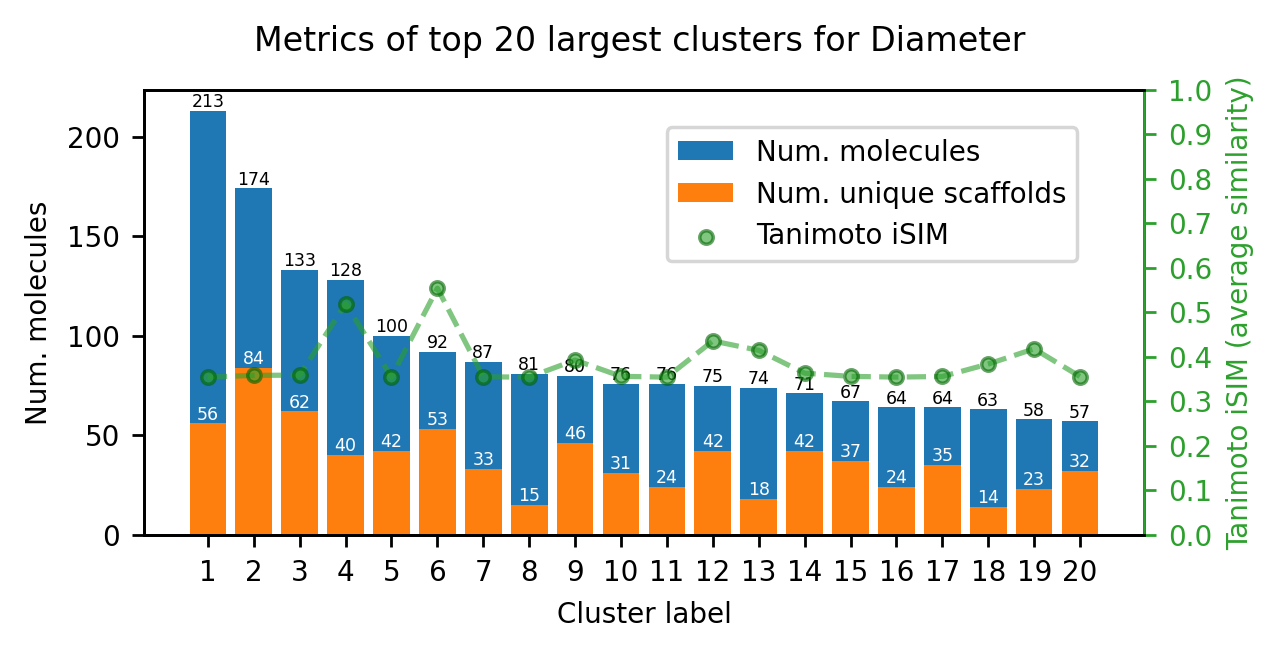

In [9]:
# First we run a cluster analysis on the resulting ids
clusters = bb_tree.get_cluster_mol_ids()
ca = analysis.cluster_analysis(clusters, fps, smiles)

# Afterwards we can use the utility functions on the bblean.plotting module
plotting.summary_plot(ca, title="Diameter")

In [19]:
# Total clusters
print("Number of clusters: ", len(clusters))

# Clusters with more than 10 molecules
large_clusters = [c for c in clusters if len(c) > 10]
print("Number of clusters with more than 10 molecules: ", len(large_clusters))

Number of clusters:  1603
Number of clusters with more than 10 molecules:  226


We can visually inspect an individual cluster by calling
`plotting.dump_mol_images`. By default this generates multiple images with 30
molecules each.

In [ ]:
plotting.dump_mol_images(smiles, clusters, cluster_idx=0)

We can also visualize the clusters using a t-SNE plot with `plotting.tsne_plot`:

(<Figure size 1000x875 with 2 Axes>,
 (<Axes: xlabel='t-SNE component 1', ylabel='t-SNE component 2'>,))

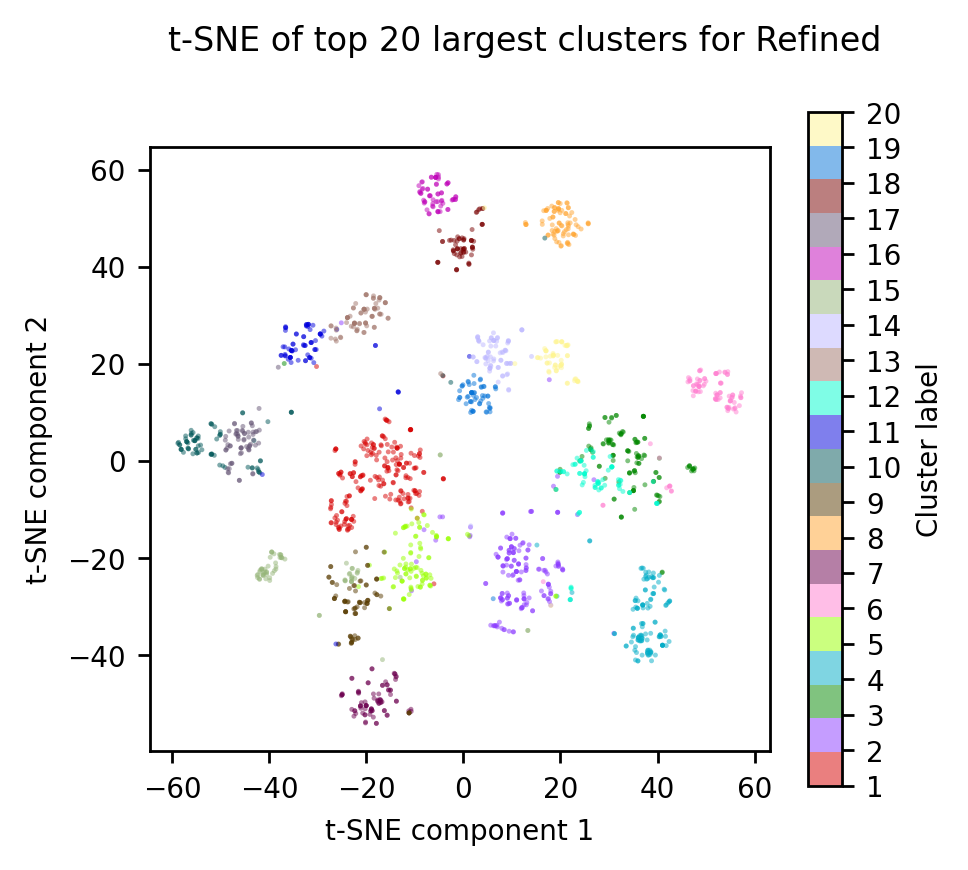

In [22]:
plotting.tsne_plot(ca, title="Refined")

## Final cluster assignments

Once we are happy with the clustering results, we can save the final cluster
assignments. to a `*.csv` file.

In [8]:
bb_tree.dump_assignments("smiles-assignments.csv", smiles)